# Linear Regression with Time Series

## Contributers: Priyanka Durai, Alex Dieter, Wendy ___

This notebook introduces linear regression with time series using the ` store sales dataset from Kaggle. 

We will:

* Explain the basic logic behind time series
* Load the store sales dataset
* Add time-step features and fit a linear regression
* Add lag features and fit a linear regression
* Alex's thing

This notebook is intended for students who have a basic understanding of Python and linear regression, but no prior experience with time series.

## Time Series

A time series is simply a dataset of sequential observations measured at successive points in time. Unlike most datasets where each row is taken to be independent, time series data is ordered (each observation often influences the ones after it). This component of dependence differentiates time series analysis from simple regression problems.

Our store sales data is a great example, because yesterday's sales will help explain today's.

### Connection to regression 

We can understand time series as examining a trend over time. If we treat time as a numerical predictor, we are able to apply linear regression. 

There are limitations to this due to a violation in linear regression's independence assumption, but we attempt to reconcile that with techniques such as adding lag features.

Our first step towards fitting a linear regression with time series modeling will be setting up our workspace with the appropriate packages, and loading in the needed data. 

In [ ]:
# This notebook includes code adapted from Kaggle
# Source: https://www.kaggle.com/code/ryanholbrook/exercise-linear-regression-with-time-series
# Licensing?
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv('data/train.csv',
    dtype=dtype,
    parse_dates=['date']
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']


We'll start small, and begin incorporating time-series logic by fitting a linear regression of the store sales data with a time-step feature:



In [3]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame()
time =  np.arange(len(df))

df['time'] = time 

X = df[['time']]  
y = df[['sales']] 

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X)[:,0], index=X.index)
print(y_pred)

date
2013-01-01    194.232790
2013-01-02    194.427137
2013-01-03    194.621484
2013-01-04    194.815831
2013-01-05    195.010178
                 ...    
2017-08-11    520.541320
2017-08-12    520.735667
2017-08-13    520.930014
2017-08-14    521.124361
2017-08-15    521.318708
Freq: D, Length: 1684, dtype: float64


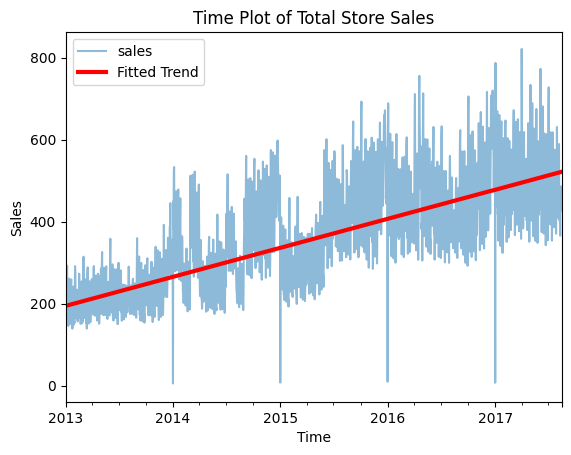

In [6]:
ax = y.plot(alpha=0.5, label='Actual Sales')
y_pred.plot(ax=ax, linewidth=3, color='red', label='Fitted Trend')
ax.set_title('Time Plot of Total Store Sales')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
ax.legend()

plt.show()

Fitting a linear regression with lag features:

In [9]:
df = average_sales.to_frame()

lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1

X = df.loc[:, ['lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'sales']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
print(y_pred)

date
2013-01-02     85.301689
2013-01-03    297.268250
2013-01-04    239.451340
2013-01-05    236.444550
2013-01-06    289.219421
                 ...    
2017-08-11    363.958893
2017-08-12    439.106384
2017-08-13    424.615509
2017-08-14    455.968994
2017-08-15    410.998535
Freq: D, Length: 1683, dtype: float32


Plot the results

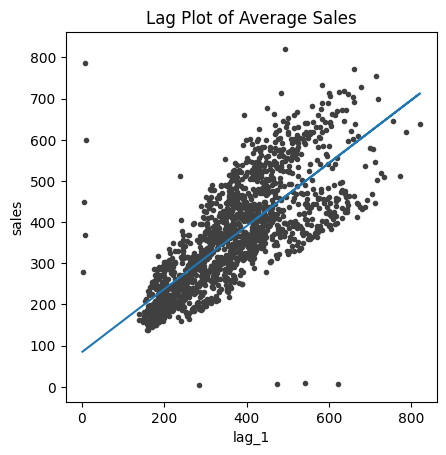

In [11]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

Combine features ( time + lag + day of the week)

In [13]:
df = average_sales.to_frame()

df['time'] = np.arange(len(df))

df['lag_1'] = df['sales'].shift(1)

df['dow'] = df.index.to_timestamp().dayofweek 
dow_dummies = pd.get_dummies(df['dow'], prefix='dow', drop_first=True)
df = pd.concat([df, dow_dummies], axis=1)

df = df.dropna()

X_train = df.drop(columns=['sales'])
y_train = df['sales']

Implementing test data

In [16]:
test_sales = pd.read_csv('data/test.csv',
    dtype=dtype,
    parse_dates=['date']
)

test_sales = test_sales.set_index('date').to_period('D')
test_sales = test_sales.set_index(['store_nbr', 'family'], append=True)

average_test_sales = test_sales.groupby('date').mean()

Add time, lag, and day of week to TEST

In [26]:
df_test = average_test_sales.copy()


df_test['time'] = np.arange(len(average_sales),
                            len(average_sales) + len(df_test))

last_train_value = average_sales.iloc[-1]

df_test['lag_1'] = np.nan
df_test.loc[df_test.index[0], 'lag_1'] = last_train_value

df_test['lag_1'] = df_test['lag_1'].ffill()

df_test['dow'] = df_test.index.to_timestamp().dayofweek
dow_dummies_test = pd.get_dummies(df_test['dow'], prefix='dow', drop_first=True)
df_test = pd.concat([df_test, dow_dummies_test], axis=1)

df_test = df_test.reindex(columns=X_train.columns, fill_value=0)

model = LinearRegression()
model.fit(X_train, y_train)

test_pred = model.predict(df_test)



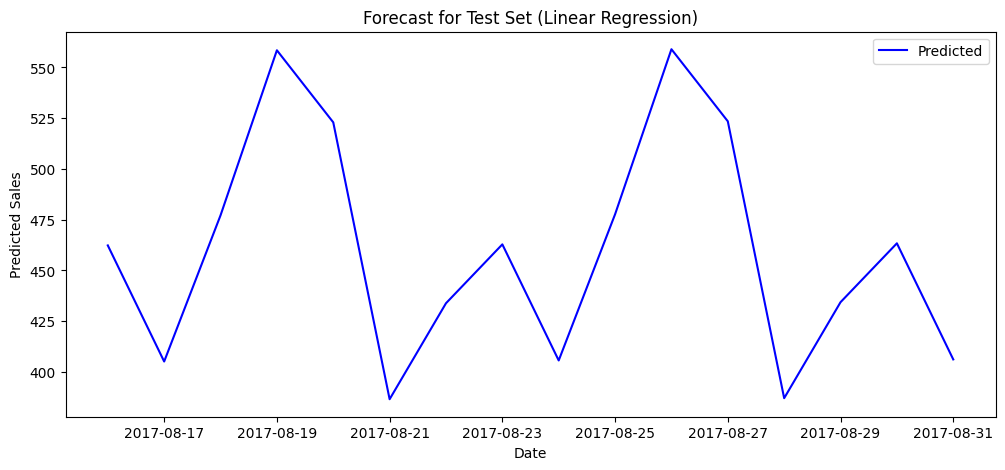

In [27]:

test_pred = pd.Series(test_pred, index=df_test.index, name='predicted_sales')

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test_pred.index.to_timestamp(), test_pred, label='Predicted', color='blue')
plt.title("Forecast for Test Set (Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# In-sample predictions on the training period
y_train_pred = pd.Series(model.predict(X_train), index=X_train.index, name='fitted_sales')

mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

print("Training MAE:", mae_train)
print("Training RMSE:", rmse_train)

Training MAE: 33.476085436674204
Training RMSE: 53.902349276847694


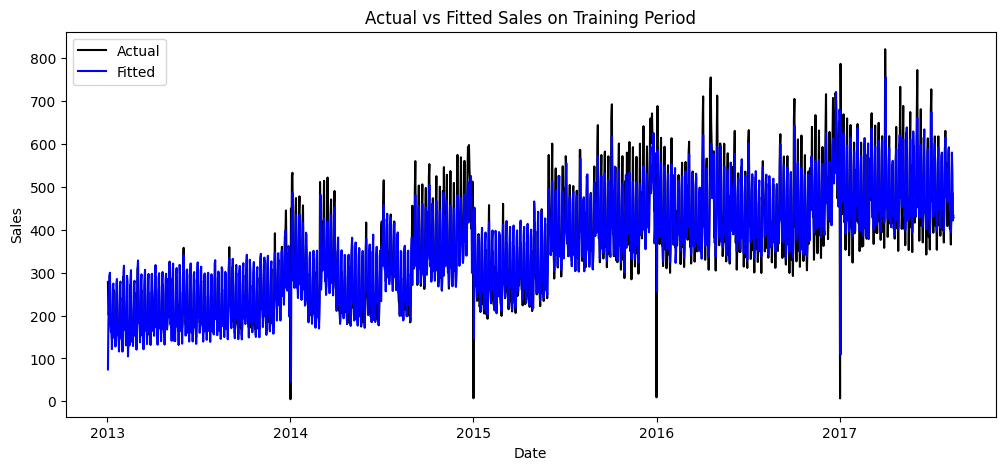

In [29]:
plt.figure(figsize=(12,5))
plt.plot(y_train.index.to_timestamp(), y_train, label='Actual', color='black')
plt.plot(y_train_pred.index.to_timestamp(), y_train_pred, label='Fitted', color='blue')
plt.title("Actual vs Fitted Sales on Training Period")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

We built a basic time-series forecasting model using linear regression to predict average daily sales from the Store Sales dataset. We first loaded and cleaned the data, then created three kinds of features that time-series models commonly use: a time index to capture overall trends, a lag-1 feature to use the previous day’s sales as a predictor, and day-of-week dummy variables to account for weekly patterns. After creating these features, we trained a linear regression model on the training period and used it to generate predictions for the test period. We evaluated the model using MAE and RMSE, which showed average errors of about 33–54 units, meaning the model follows the general pattern of sales but still has noticeable day-to-day deviations. The fitted-vs-actual plot on the training data shows that the model captures the long-term upward trend and weekly cycles, while the test-set forecast demonstrates how the model projects future sales based on the recent past. Overall, this assignment demonstrated how simple feature engineering and linear regression can be used to make baseline forecasts for time-series data.